# AI-Generated Image Detection

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd
import seaborn as sns

import pathlib
from zipfile import ZipFile
import imagehash
import random

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unzipped to access the images

In [126]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [127]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [128]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))
total_dataset = train_img_array + test_img_array

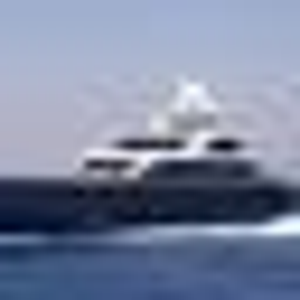

In [129]:
# Display random image in the dataset
random_number = random.randint(0, len(train_img_array))
Image.open(str(train_img_array[random_number])).resize((300, 300))

#### Information about the dataset

In [130]:
# Check the number of items in the dataset
print(f"Training image count : {len(train_img_array)} \nTesting image count : {len(test_img_array)} \nTotal data : {len(total_dataset)}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


In [131]:
# Check the number of type image extension in the dataset
image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

# train_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

# test_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

def count_filetype(dataset, type_array):
    type_count = len(type_array)
    for c, file_name in enumerate(dataset):
        # Split the file name by the period (.) character
        parts = str(file_name).split(".")
        file_extension = str(parts[-1]).lower() # Get the extension type.
        # print("outer loop : ", c)
        for counter in range(type_count):
            # print("inner loop : ", counter)
            if file_extension == type_array[counter]["file_type"]:
                type_array[counter]["count"]+=1
                break
            if counter == (type_count - 1): # If the loop falls in the "other category"
                type_array[-1]["count"]+=1


# Counts image types occurrence for dataset 
count_filetype(total_dataset, image_types)

# Counts image types occurrence for training set 
# count_filetype(train_img_array, train_image_types)

# Counts image types occurrence for testing set 
# count_filetype(test_img_array, test_image_types)


# Display result for train dataset
for image_type in image_types:
  print(f"Number of {image_type['file_type']} images inside the dataset : {image_type['count']}")
  
# # Display result for train dataset
# for image_type in train_image_types:
#   print(f"Number of {image_type['file_type']} images inside the training dataset : {image_type['count']}")

# print("----------------------------------------------")
# Display result for test dataset
# for image_type in test_image_types:
#   print(f"Number of {image_type['file_type']} images inside the testing dataset : {image_type['count']}")

Number of jpeg images inside the dataset : 0
Number of png images inside the dataset : 0
Number of jpg images inside the dataset : 120000
Number of other images inside the dataset : 0


- We can observe that the dataset only contains jpg images in both the training and testing dataset

### 2.  Data cleaning

#### Check if the dataset contains corrupted and duplicated images.

In [132]:
def clean_image_data(dataset: list):
    # cleaned_images = []
    cleaned_images = 0
    # corrupted_images = []
    corrupted_images = 0
    imgs_shape = []  
    hash_dict = {}
    # duplicate_images = []  
    duplicate_images = 0  
    temp_dataset: list[bool] = [] 

    for count, filename in enumerate(dataset):
        filename = str(filename)
        try:
            with Image.open(filename) as img:
                # Optionally, perform additional checks such as size, format, etc.
                # Check image size
                # if img.size < min_size:
                #     print(f"Ignoring small image: {filename}")
                #     continue
                
                # print("image size : ", img.size)
                
                # img_width.append(img.size[0])
                # img_height.append(img.size[1])
                # Calculate the hash of the image
                img_hash = imagehash.average_hash(img)

                # Check if the hash already exists in the dictionary
                if img_hash in hash_dict:
                    duplicate_images+=1
                    temp_dataset.append(True)
                    # duplicate_images.append([filename, True])
                else:
                    hash_dict[img_hash] = filename
                    temp_dataset.append(False)
                    
                imgs_shape.append(img.size)
                cleaned_images+=1
                # cleaned_images.append(filename)
        except Exception as e:
            # Handle corrupted or unreadable images
            # corrupted_images.append(filename)
            corrupted_images+=1
            print(f"Corrupted image: {filename}, Error: {e}")

    return cleaned_images, corrupted_images, duplicate_images, temp_dataset, imgs_shape
# , img_width, img_height

# data_directory = train_img_array
cleaned_images, corrupted_images, duplicate_images, duplicates_values, imgs_shape = clean_image_data(total_dataset)
# , img_width, img_height = clean_image_data(total_dataset)

print(f"Cleaned images: {cleaned_images}")
print(f"Corrupted images: {corrupted_images}")
print("duplicate images : ", duplicate_images )
print("temp : ", len(duplicates_values) )
# print("duplicate images : ", hash_dict )

Cleaned images: 120000
Corrupted images: 0
duplicate images :  3342
temp :  120000


- We observe that the dataset does not contain any corrupted image
- However duplicates images are in the dataset.

- Duplicated images are based on the image content rather than filenames. 
- The process to find duplicated images is as follows:
    - Turn the image content into a hash value and get the average value of the hash.
    - Compare images hash value and determine if there are duplicate or near-duplicate images based on similarity thresholds.

In [135]:
# Transforming the dataset list into a pandas.Series Dataframe 
df = pd.DataFrame(total_dataset, columns=["Filename"])
shapes = pd.DataFrame(imgs_shape, columns=["width", "height"])
dupl = pd.DataFrame(duplicates_values, columns=["duplicated"])

df = df.merge(shapes, left_index=True, right_index=True)

# merge_df = df.merge(dupl, left_index=True, right_index=True)

In [136]:
# Remove duplicates
print("Before Duplicates :", len(df))

df = df[~dupl["duplicated"]]

print("After removing duplicates :", len(df))

Before Duplicates : 120000
After removing duplicates : 116658


In [137]:
df.reset_index(drop=True)

Filename  width  height
0       train/REAL/4053 (9).jpg     32      32
1       train/REAL/2864 (4).jpg     32      32
2       train/REAL/3536 (3).jpg     32      32
3       train/REAL/0183 (8).jpg     32      32
4       train/REAL/1607 (8).jpg     32      32
...                         ...    ...     ...
116653    test/FAKE/357 (8).jpg     32      32
116654        test/FAKE/612.jpg     32      32
116655    test/FAKE/603 (9).jpg     32      32
116656        test/FAKE/282.jpg     32      32
116657    test/FAKE/234 (6).jpg     32      32

[116658 rows x 3 columns]

In [138]:
# creating new columns to tag data inside the dataset
df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train") 
df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE") 

/tmp/ipykernel_6206/2603787530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train")
/tmp/ipykernel_6206/2603787530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE")


In [143]:
df.head()

Filename  width  height folder_type   tag
0  train/REAL/4053 (9).jpg     32      32       Train  REAL
1  train/REAL/2864 (4).jpg     32      32       Train  REAL
2  train/REAL/3536 (3).jpg     32      32       Train  REAL
3  train/REAL/0183 (8).jpg     32      32       Train  REAL
4  train/REAL/1607 (8).jpg     32      32       Train  REAL

### 3.  Data exploration

In [148]:
df.describe()

width    height
count  116658.0  116658.0
mean       32.0      32.0
std         0.0       0.0
min        32.0      32.0
25%        32.0      32.0
50%        32.0      32.0
75%        32.0      32.0
max        32.0      32.0

In [146]:
df.describe(include=['object'])

Filename folder_type     tag
count                    116658      116658  116658
unique                   116658           2       2
top     train/REAL/4053 (9).jpg       Train    REAL
freq                          1       97536   59123

In [98]:
# Get the number of "REAL" and "FAKE" tags
num_real_tags = df["tag"].apply(lambda x: x.count("REAL")).sum()
num_fake_tags = df["tag"].apply(lambda x: x.count("FAKE")).sum()

# Get the number of "Train" and "Test" type
num_train = df["folder_type"].apply(lambda x: x.count("Train")).sum()
num_test = df["folder_type"].apply(lambda x: x.count("Test")).sum()

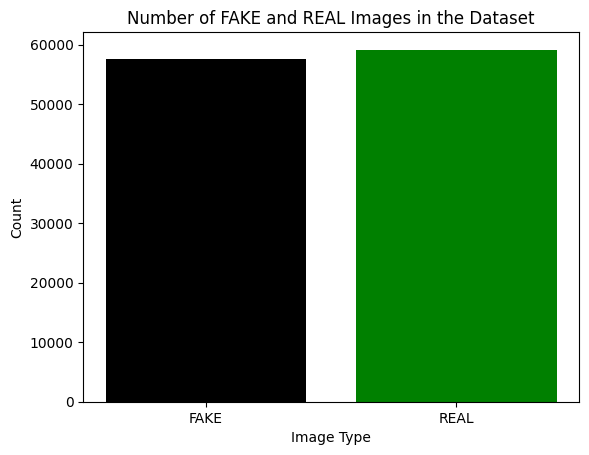

Number of 'FAKE' images: 57535
Number of 'REAL' images: 59123
Difference: 1588


In [113]:
# Create a bar chart
plt.bar(['FAKE', 'REAL'], [num_fake_tags, num_real_tags], color=["black", "green"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of FAKE and REAL Images in the Dataset')
plt.show()
print("Number of 'FAKE' images:", num_fake_tags)
print("Number of 'REAL' images:", num_real_tags)
print("Difference:", num_real_tags - num_fake_tags)

-   from this chart it is noticeable that the difference between REAL and FAKE images is not much

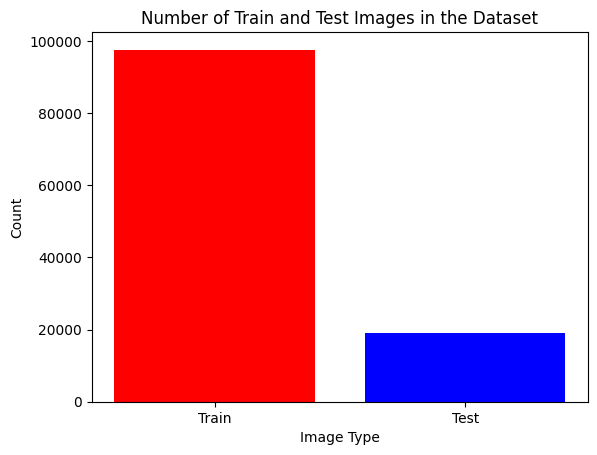

Number of 'Train' images: 97536
Number of 'Test' images: 19122
Test set represents 20% of the Train set


In [124]:
# Create a bar chart
plt.bar(['Train', 'Test'], [num_train, num_test], color=["red", "blue"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of Train and Test Images in the Dataset')
plt.show()
print("Number of 'Train' images:", num_train)
print("Number of 'Test' images:", num_test)
print("Test set represents {:.0f}% of the Train set".format((num_test / num_train) * 100))

- From this chart, we observe that the dataset has been split with a 80:20 ratio.

#### Next steps :
-   Explain how duplicated data were found + remove it from dataset.
-   Display shape of all images (width and height)
-   Search what the batch size is for on tensorflow keras
-   Investigate if it is needed to handle noisy data in the dataset

In [57]:
test = df["Filename"].to_list()

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [58]:
dataset = tf.data.Dataset.from_tensor_slices(test)

ValueError: Attempt to convert a value (PosixPath('train/REAL/4053 (9).jpg')) with an unsupported type (<class 'pathlib.PosixPath'>) to a Tensor.

In [56]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  test[0],
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

NotFoundError: Could not find directory train/REAL/4053 (9).jpg